# aSPEM Experiment : analysis



TODO: clean-up garder blocs indep full R

TODO: moulinette statistique ? https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test https://en.wikipedia.org/wiki/Earth_mover%27s_distance

TODO: https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot

TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
import pickle
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [5]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [6]:
def maxx_pourcentage(r_, pourcentage) :
    maxx=None
    for round_ in list(reversed(np.arange(5))) :
        if maxx is None :
            for x in range(len(r_)) :
                if np.round(r_[x], round_)==np.round(pourcentage*np.max(r_), round_) :
                    maxx=x
    return maxx

In [7]:
def print_stat(h, age) :
    from scipy import stats
    
    print('\nH vs F', end=' -> ')
    print('mannwhitneyu=%.4f'%stats.mannwhitneyu(h['F'], h['M']).pvalue,
          'kruskal=%.4f'%stats.kruskal(h['F'], h['M']).pvalue,
          'ks_2samp=%.4f'%stats.ks_2samp(h['F'], h['M']).pvalue, sep='  ')
          #'\nwasserstein_distance (Earth movers distance) : ',
          #stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')

    for b1 in range(2) :
        for b2 in range(1, 3) :
            if b1!=b2 :
                print('BLOCK %s vs %s'%(b1,b2), end=' -> ')
                print('mannwhitneyu=%.4f'%stats.mannwhitneyu(h['b'][b1], h['b'][b2]).pvalue,
                      'kruskal=%.4f'%stats.kruskal(h['b'][b1], h['b'][b2]).pvalue,
                      'ks_2samp=%.4f'%stats.ks_2samp(h['b'][b1], h['b'][b2]).pvalue, sep='  ')

    for a1 in age[:2] :
        for a2 in age[1:] :
            if a1!=a2 :
                print('AGE %s vs %s'%(a1,a2), end=' -> ')
                print('mannwhitneyu=%.4f'%stats.mannwhitneyu(h[a1], h[a2]).pvalue,
                      'kruskal=%.4f'%stats.kruskal(h[a1], h[a2]).pvalue,
                      'ks_2samp=%.4f'%stats.ks_2samp(h[a1], h[a2]).pvalue, sep='  ')

In [8]:
suj = ['AM', 'BMC', 'CS', 'DC', 'FM', 'IP', 'LB', 'OP', 'RS', 'SR',  'TN', 'YK']

list_suj = {'AM': 'F', 'BMC': 'M', 'CS': 'F', 'DC': 'F',
            'FM': 'F', 'IP': 'F',  'LB': 'F', 'OP': 'M',
            'RS': 'M', 'SR': 'F',  'TN': 'M', 'YK': 'M'}

age_suj = {'AM': 44, 'BMC': 24, 'CS': 28, 'DC': 27,
           'FM': 30, 'IP': 26,  'LB': 27, 'OP': 31,
           'RS': 28, 'SR': 25,  'TN': 28, 'YK': 30}

# 2 sujet -25  # 6 sujet 26-29 # 4 sujets 30-
# 3 sujet -26  # 5 sujet 27-29 # 4 sujets 30-

age_suj = {'AM': '30-', 'BMC': '-26', 'CS': '27-29', 'DC': '27-29',
           'FM': '30-', 'IP': '-26',  'LB': '27-29', 'OP': '30-',
           'RS': '27-29', 'SR': '-26',  'TN': '27-29', 'YK': '30-'}

In [9]:
def plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=0.99, triangle=True) :
    
    if triangle is True : from matplotlib.patches import Polygon
    
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:max_tau]
    COLOR = ['b', 'r', 'k', 'g', 'm', 'c', 'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']
    
    fig = plt.figure(figsize=(15,15))
    import matplotlib.gridspec as gridspec
    #gs = gridspec.GridSpec(5, 5)
    #'''ax_ = plt.subplot(gs[1:5, :4])
    #ax_x, ax_y = plt.subplot(gs[0, :4]), plt.subplot(gs[1:5, 4])'''

    gs = gridspec.GridSpec(8, 8)
    ax_ = plt.subplot(gs[3:, :5])
    ax_x,  ax_y  = plt.subplot(gs[2, :5]), plt.subplot(gs[3:, 5])
    ax_x1, ax_y1 = plt.subplot(gs[1, :5]), plt.subplot(gs[3:, 6])
    ax_x2, ax_y2 = plt.subplot(gs[0, :5]), plt.subplot(gs[3:, 7])

    
    # DECO
    #---------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '--k', alpha=0.5)
    opt=dict(colors='k', linestyles='-', alpha=0.4)
    ax_.vlines(0.025, 0, 0.025, **opt) ; ax_.hlines(0.025, 0, 0.025, **opt)
    ax_.set_xlabel('$h_{va}$', fontsize=20) ; ax_.set_ylabel('$h_{bet}$', fontsize=20)
    
    lim = (min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    ax_xC, ax_yC = ax_x.twinx(), ax_y.twiny()
    ax_x1C, ax_y1C, ax_x2C, ax_y2C = ax_x1.twinx(), ax_y1.twiny(), ax_x2.twinx(), ax_y2.twiny()
    
    for a,l in zip([ax_xC,ax_x1C,ax_x2C], ['H vs F','Block','age']) : a.set_ylabel(l,color='k') ; a.tick_params('y',colors='r')
    for a,l in zip([ax_yC,ax_y1C,ax_y2C], ['H vs F','Block','age']) : a.set_xlabel(l,color='k') ; a.tick_params('x',colors='r')
    
    lim = (np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
    for a in [ax_x, ax_xC, ax_x1, ax_x1C, ax_x2, ax_x2C] : a.set_xlim(lim) ; a.set_xticks(())
    for a in [ax_y, ax_yC, ax_y1, ax_y1C, ax_y2, ax_y2C] : a.set_ylim(lim) ; a.set_yticks(())

    #axis_r = [min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100,
    #          min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100]
    
    #---------------------------------------------------------------
    age=['-26', '27-29', '30-']
    
    h_va, h_bet, r_va, r_bet = {}, {}, {}, {}
    for l in [h_va, h_bet, r_va, r_bet] :
        l['full'], l['b'] = [], [[],[],[]]
        for s in ['F', 'M'] : l[s]=[]
        for a in age :        l[a]=[]
        
    #---------------------------------------------------------------
    for num, s in enumerate(suj) :
        if list_suj[s]=='F' : coco='r'
        else :                coco='b'
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :
            r_va_d, r_bet_d = recording['r_va'][s][d][:max_tau], recording['r_bet'][s][d][:max_tau]

            if pourcentage is not None :
                #pourcentage
                #-----------------------------------------------------------------------
                if np.argmax(r_va_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_va_d, pourcentage)
                    r_va_s.append(r_va_d[maxx]) ; h_va_s.append(list_h[maxx])
                else : r_va_s.append(np.max(r_va_d)) ; h_va_s.append(list_h[np.argmax(r_va_d)])

                if np.argmax(r_bet_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_bet_d, pourcentage)
                    r_bet_s.append(r_bet_d[maxx])   ; h_bet_s.append(list_h[maxx])
                else : r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                #-----------------------------------------------------------------------
            else :
                r_va_s.append(np.max(r_va_d))   ; h_va_s.append(list_h[np.argmax(r_va_d)])
                r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])
                
            h_va['b'][d].append(h_va_s[d]) ; h_bet['b'][d].append(h_bet_s[d])
            r_va['b'][d].append(r_va_s[d]) ; r_bet['b'][d].append(r_bet_s[d])
        
        #-----------------------------------------------------------------------
        if triangle is True :
            tritri = np.array([[h_va_s[y], h_bet_s[y]] for y in range(len(h_va_s))])
            popo = Polygon(tritri, edgecolor=coco, alpha=0.5, lw=1.5, facecolor='none') # color=COLOR[num]
            ax_.add_artist(popo)
        
        #-----------------------------------------------------------------------           
        opt = dict(alpha=0.5, lw=0, edgecolors=coco) # c=COLOR[num], lw=3
        ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*400,
                    marker='*' if s in ['TN', 'LB'] else None,
                    zorder=100  if s in ['TN', 'LB'] else 50, c='g', **opt)
        ax_.scatter(h_va_s[1:], h_bet_s[1:], s=(np.array(r_va_s[1:])*np.array(r_bet_s[1:]))*400,
                    c=['y', 'r'], zorder=50, **opt)
        
        #-----------------------------------------------------------------------
        h_va['full'].extend(h_va_s) ; h_bet['full'].extend(h_bet_s)
        r_va['full'].extend(r_va_s) ; r_bet['full'].extend(r_bet_s)
        
        for arg in [list_suj[s], age_suj[s]] :
            h_va[arg].extend(h_va_s[b] if np.isnan(h_bet_s[b])==False else np.nan for b in range(len(h_va_s)))
            h_bet[arg].extend(h_bet_s[b] if np.isnan(h_va_s[b])==False else np.nan for b in range(len(h_va_s)))
            r_va[arg].extend(r_va_s)
            r_bet[arg].extend(r_bet_s)
    
    h_va['full'], h_bet['full'], r_va['full'], r_bet['full'] = mask_nan(h_va['full'], h_bet['full'], r_va['full'], r_bet['full'])
    r_va['full'], r_bet['full'] = np.array(r_va['full']), np.array(r_bet['full'])

    #--------------------------------------------------------------------------------------------
    # HISTOGRAMME
    #--------------------------------------------------------------------------------------------
    c_ = ['g', 'y', 'r']
    opt = dict(range=(np.log(min(list_h)), np.log(max(list_h))), bins=20, alpha=0.3)
    opt_c = dict(range=(np.log(min(list_h)-min(list_h)/9), np.log(max(list_h)+max(list_h)/9)),
                 bins=len(list_h), cumulative=True, histtype='step', align='mid', lw=1.5, density=True)
    
    # hist VA
    #--------------------------------------------------------------------
    for a_x, a_xC in zip([ax_x, ax_x1, ax_x2], [ax_xC, ax_x1C, ax_x2C]) :
        a_x.hist(np.log(h_va['full']), weights=r_va['full'], color='k', **opt)
        a_xC.hist(np.log(h_va['full']), weights=r_va['full'], color='k', **opt_c)
    
    for a, o in zip([ax_x, ax_xC], [opt, opt_c]) :
        a.hist([np.log(h_va['F']), np.log(h_va['M'])], weights=[r_va['F'], r_va['M']], color=['r', 'b'], **o)
    
    for AX, o in zip([[ax_x1, ax_x2], [ax_x1C, ax_x2C]], [opt, opt_c]) :
        for a, hv, rv in zip(AX, [h_va['b'], [h_va[a] for a in age]], [r_va['b'], [r_va[a] for a in age]]) :
            a.hist([np.log(hv[0]), np.log(hv[1]), np.log(hv[2])], weights=[rv[0], rv[1], rv[2]], color=c_, **o)
    
    # hist BET
    #--------------------------------------------------------------------
    opt['orientation'], opt_c['orientation'] = "horizontal", "horizontal"
    
    for a_y, a_yC in zip([ax_y, ax_y1, ax_y2], [ax_yC, ax_y1C, ax_y2C]) :
        a_y.hist(np.log(h_bet['full']), weights=r_bet['full'], color='k', **opt)
        a_yC.hist(np.log(h_bet['full']), weights=r_bet['full'], color='k', **opt_c)
        
    for a, o in zip([ax_y, ax_yC], [opt, opt_c]) :
        a.hist([np.log(h_bet['F']), np.log(h_bet['M'])],weights=[r_bet['F'], r_bet['M']], color=['r', 'b'],  **o)
        
    for AX, o in zip([[ax_y1, ax_y2], [ax_y1C, ax_y2C]], [opt, opt_c]) :
        for a, hv, rv in zip(AX, [h_bet['b'], [h_bet[a] for a in age]], [r_bet['b'], [r_bet[a] for a in age]]) :
            a.hist([np.log(hv[0]), np.log(hv[1]), np.log(hv[2])], weights=[rv[0], rv[1], rv[2]], color=c_, **o)
    #--------------------------------------------------------------------
    
    for c in coupe :
        opt=dict(colors='r', linestyles='-', alpha=0.2, lw=1)
        ax_.vlines(c, 0, 10, **opt) ; ax_.hlines(c, 0, 10, **opt)
    
    plt.show()
    
    #--------------------------------------------------------------------------------------------
    # STAT
    #--------------------------------------------------------------------------------------------
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], ['h_va', 'h_bet']) :
        print('\n\n', '-'*70,'\n%s\n'%title, '-'*70, sep='')        
        print_stat(h, age)

        for c in coupe :
            print('\n\nCoupe à h=%s, tau=%s\n'%(c, 1/c), '-'*30, sep='')

            full_h = [h['F'], h['M'], h['b'][0], h['b'][1], h['b'][2]]
            full_h.extend(h[a] for a in age)
            
            for h_g in full_h :
                g=0
                while g < len(h_g) :
                    if h_g[g] < c : del h_g[g]
                    else :          g=g+1

            print_stat(h, age)
    #--------------------------------------------------------------------------------------------
        
    return fig

In [10]:
file = os.path.join('parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')

AM BMC CS DC FM IP LB OP RS SR TN YK 

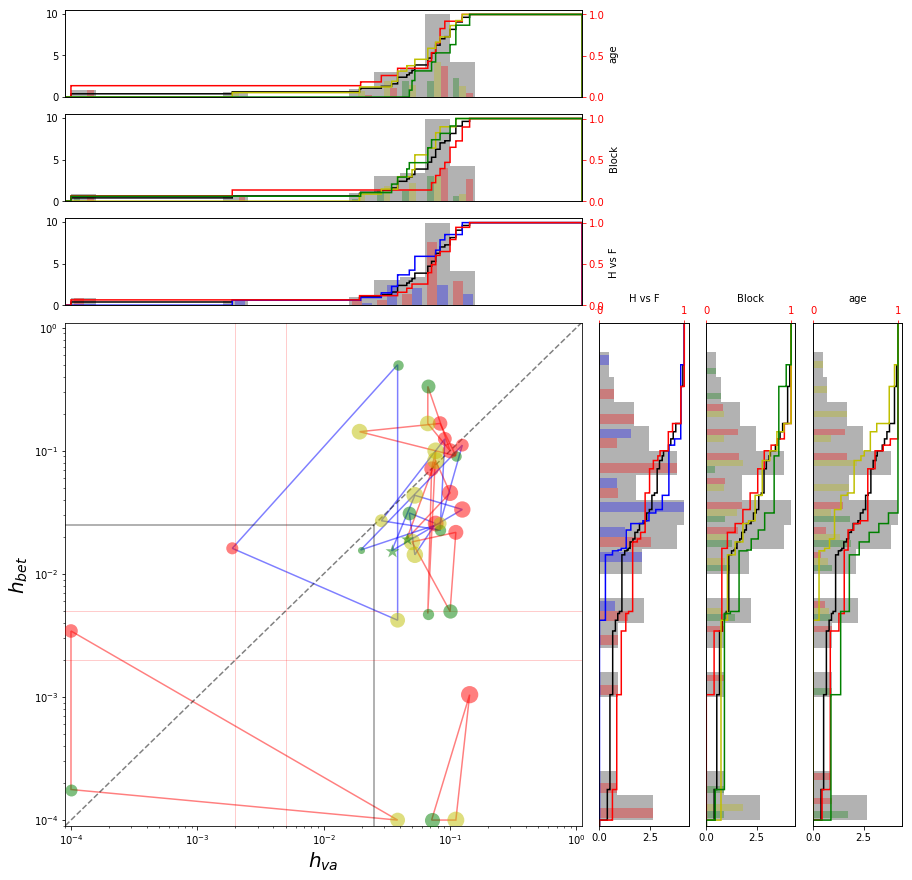



----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.1756  kruskal=0.3430  ks_2samp=0.2886
BLOCK 0 vs 1 -> mannwhitneyu=0.4654  kruskal=0.9078  ks_2samp=0.9985
BLOCK 0 vs 2 -> mannwhitneyu=0.0230  kruskal=0.0429  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.0200  kruskal=0.0373  ks_2samp=0.0995
AGE -26 vs 27-29 -> mannwhitneyu=0.0846  kruskal=0.1600  ks_2samp=0.2653
AGE -26 vs 30- -> mannwhitneyu=0.0826  kruskal=0.1545  ks_2samp=0.2681
AGE 27-29 vs 30- -> mannwhitneyu=0.3388  kruskal=0.6598  ks_2samp=0.9059


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.1039  kruskal=0.2013  ks_2samp=0.1920
BLOCK 0 vs 1 -> mannwhitneyu=0.4145  kruskal=0.8050  ks_2samp=0.9992
BLOCK 0 vs 2 -> mannwhitneyu=0.0024  kruskal=0.0042  ks_2samp=0.0112
BLOCK 1 vs 2 -> mannwhitneyu=0.0008  kruskal=0.0015  ks_2samp=0.0067
AGE -26 vs 27-29 -> mannwhitneyu

In [11]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None)

AM BMC CS DC FM IP LB OP RS SR TN YK 

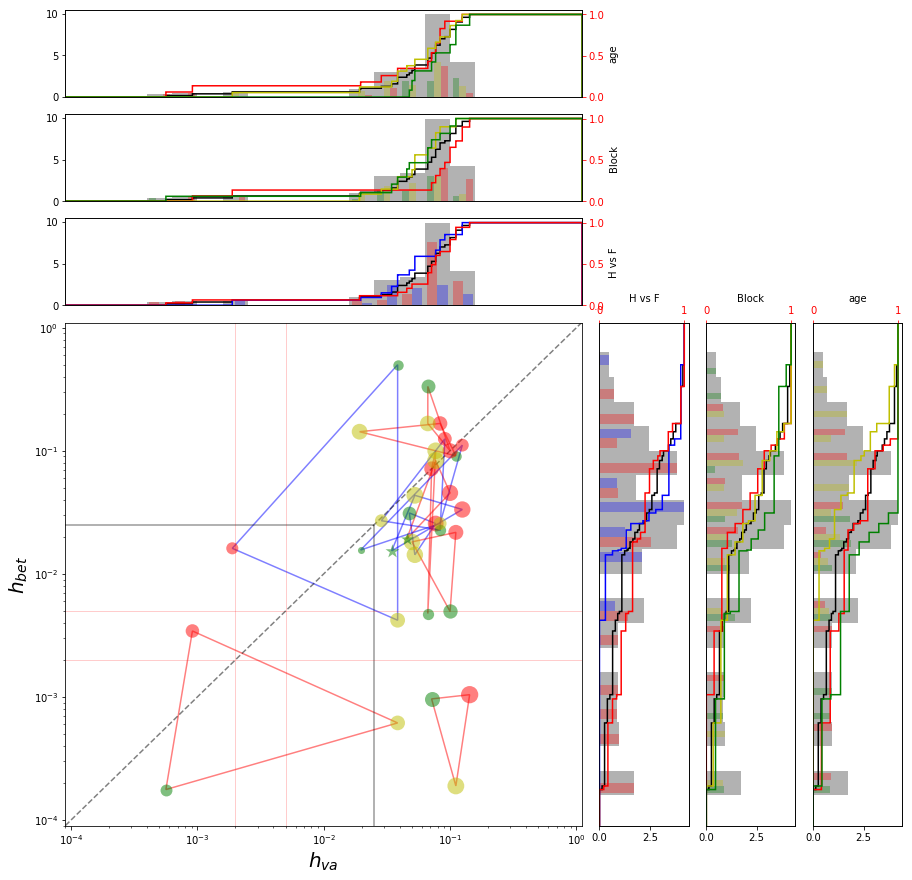



----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.1756  kruskal=0.3430  ks_2samp=0.2886
BLOCK 0 vs 1 -> mannwhitneyu=0.4654  kruskal=0.9078  ks_2samp=0.9985
BLOCK 0 vs 2 -> mannwhitneyu=0.0214  kruskal=0.0400  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.0200  kruskal=0.0373  ks_2samp=0.0995
AGE -26 vs 27-29 -> mannwhitneyu=0.0846  kruskal=0.1600  ks_2samp=0.2653
AGE -26 vs 30- -> mannwhitneyu=0.0826  kruskal=0.1547  ks_2samp=0.2681
AGE 27-29 vs 30- -> mannwhitneyu=0.3388  kruskal=0.6598  ks_2samp=0.9059


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.1039  kruskal=0.2013  ks_2samp=0.1920
BLOCK 0 vs 1 -> mannwhitneyu=0.4145  kruskal=0.8050  ks_2samp=0.9992
BLOCK 0 vs 2 -> mannwhitneyu=0.0024  kruskal=0.0042  ks_2samp=0.0112
BLOCK 1 vs 2 -> mannwhitneyu=0.0008  kruskal=0.0015  ks_2samp=0.0067
AGE -26 vs 27-29 -> mannwhitneyu

In [12]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])

---------------------------------

In [13]:
file = os.path.join('parametre', 'list_h_block_Scalling_sujet.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')

AM BMC CS DC FM IP LB OP RS SR TN YK 

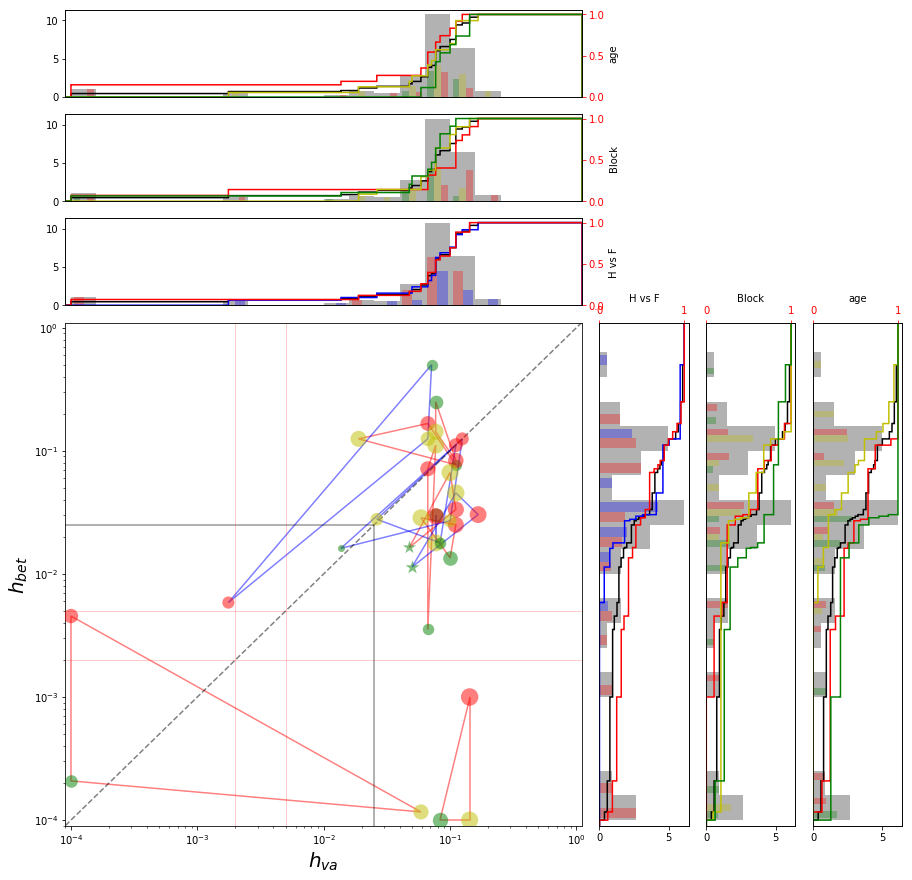



----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.4807  kruskal=0.9485  ks_2samp=0.9999
BLOCK 0 vs 1 -> mannwhitneyu=0.2905  kruskal=0.5613  ks_2samp=0.9985
BLOCK 0 vs 2 -> mannwhitneyu=0.0583  kruskal=0.1100  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.1282  kruskal=0.2444  ks_2samp=0.2558
AGE -26 vs 27-29 -> mannwhitneyu=0.1327  kruskal=0.2528  ks_2samp=0.3936
AGE -26 vs 30- -> mannwhitneyu=0.0370  kruskal=0.0684  ks_2samp=0.1590
AGE 27-29 vs 30- -> mannwhitneyu=0.1632  kruskal=0.3145  ks_2samp=0.9059


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.4562  kruskal=0.8978  ks_2samp=0.9994
BLOCK 0 vs 1 -> mannwhitneyu=0.4141  kruskal=0.8042  ks_2samp=0.9932
BLOCK 0 vs 2 -> mannwhitneyu=0.0104  kruskal=0.0190  ks_2samp=0.0303
BLOCK 1 vs 2 -> mannwhitneyu=0.0179  kruskal=0.0330  ks_2samp=0.0617
AGE -26 vs 27-29 -> mannwhitneyu

In [14]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None)

AM BMC CS DC FM IP LB OP RS SR TN YK 

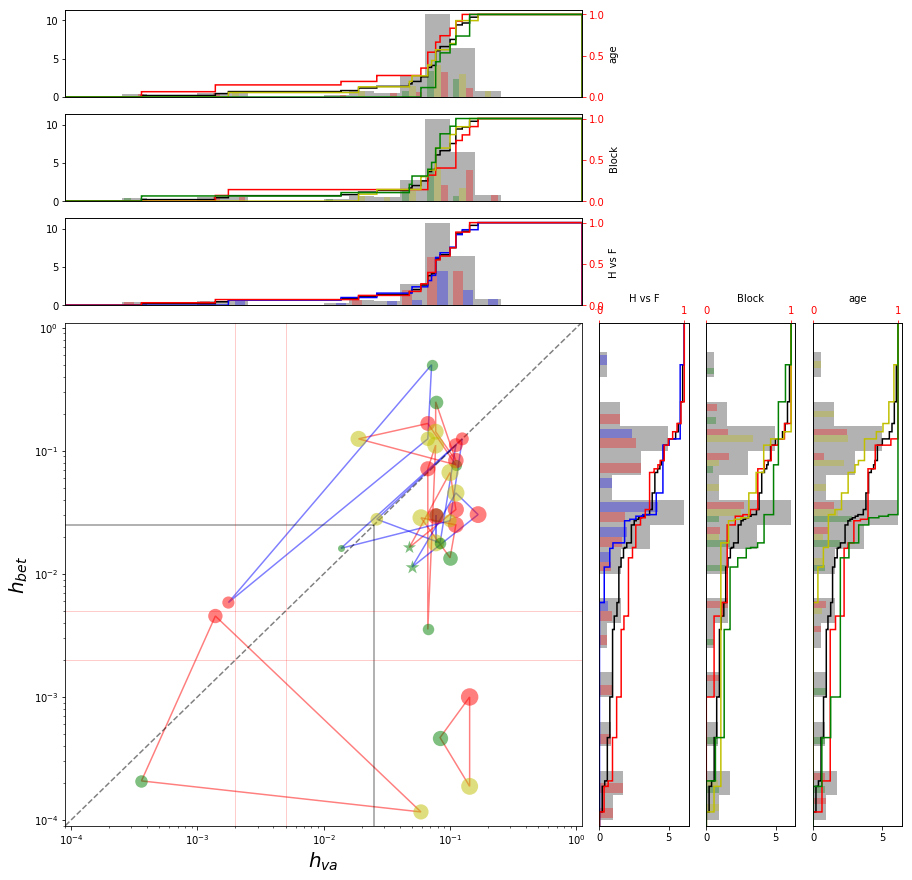



----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.4807  kruskal=0.9485  ks_2samp=0.9999
BLOCK 0 vs 1 -> mannwhitneyu=0.2905  kruskal=0.5613  ks_2samp=0.9985
BLOCK 0 vs 2 -> mannwhitneyu=0.0550  kruskal=0.1038  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.1282  kruskal=0.2444  ks_2samp=0.2558
AGE -26 vs 27-29 -> mannwhitneyu=0.1327  kruskal=0.2528  ks_2samp=0.3936
AGE -26 vs 30- -> mannwhitneyu=0.0371  kruskal=0.0685  ks_2samp=0.1590
AGE 27-29 vs 30- -> mannwhitneyu=0.1633  kruskal=0.3146  ks_2samp=0.9059


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.4562  kruskal=0.8978  ks_2samp=0.9994
BLOCK 0 vs 1 -> mannwhitneyu=0.4141  kruskal=0.8042  ks_2samp=0.9932
BLOCK 0 vs 2 -> mannwhitneyu=0.0104  kruskal=0.0190  ks_2samp=0.0303
BLOCK 1 vs 2 -> mannwhitneyu=0.0179  kruskal=0.0330  ks_2samp=0.0617
AGE -26 vs 27-29 -> mannwhitneyu

In [15]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])

---------------------------------

In [16]:
file = os.path.join('parametre', 'list_h_block_Scalling_full.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')

AM BMC CS DC FM IP LB OP RS SR TN YK 

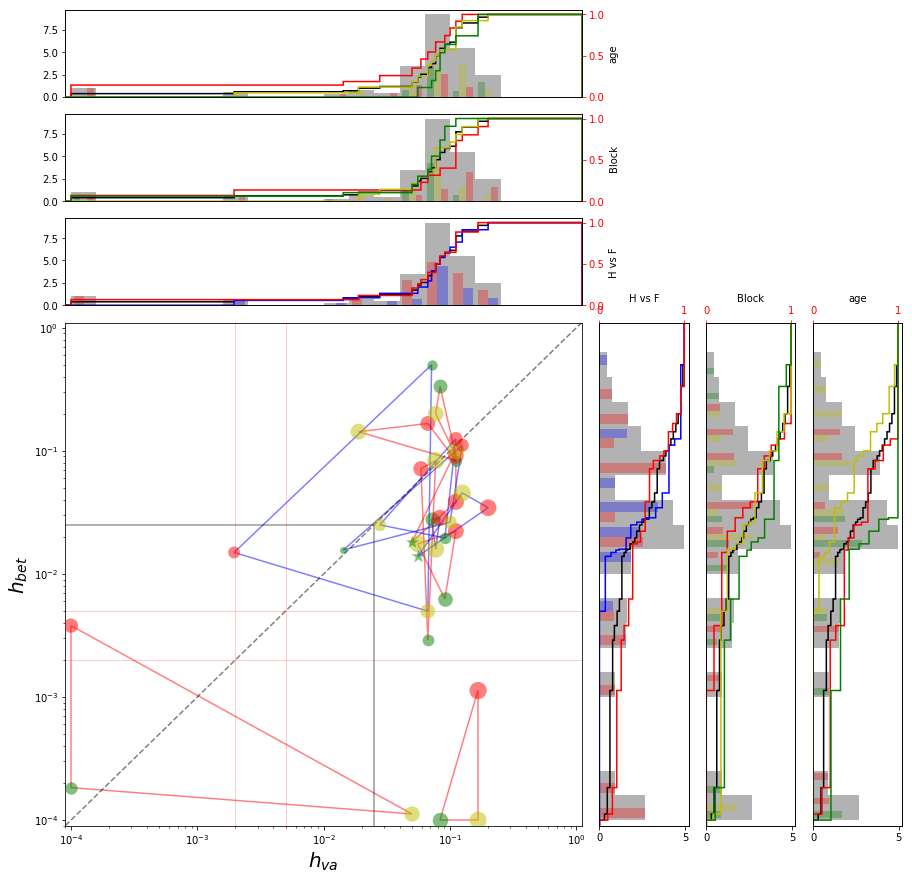



----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.4297  kruskal=0.8468  ks_2samp=0.9996
BLOCK 0 vs 1 -> mannwhitneyu=0.2912  kruskal=0.5628  ks_2samp=0.8690
BLOCK 0 vs 2 -> mannwhitneyu=0.0551  kruskal=0.1038  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.1764  kruskal=0.3379  ks_2samp=0.5361
AGE -26 vs 27-29 -> mannwhitneyu=0.1921  kruskal=0.3681  ks_2samp=0.6408
AGE -26 vs 30- -> mannwhitneyu=0.0437  kruskal=0.0811  ks_2samp=0.1590
AGE 27-29 vs 30- -> mannwhitneyu=0.1103  kruskal=0.2114  ks_2samp=0.7863


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.5000  kruskal=0.9854  ks_2samp=0.9994
BLOCK 0 vs 1 -> mannwhitneyu=0.4145  kruskal=0.8050  ks_2samp=0.7771
BLOCK 0 vs 2 -> mannwhitneyu=0.0095  kruskal=0.0173  ks_2samp=0.0303
BLOCK 1 vs 2 -> mannwhitneyu=0.0314  kruskal=0.0583  ks_2samp=0.1342
AGE -26 vs 27-29 -> mannwhitneyu

In [17]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None)

AM BMC CS DC FM IP LB OP RS SR TN YK 

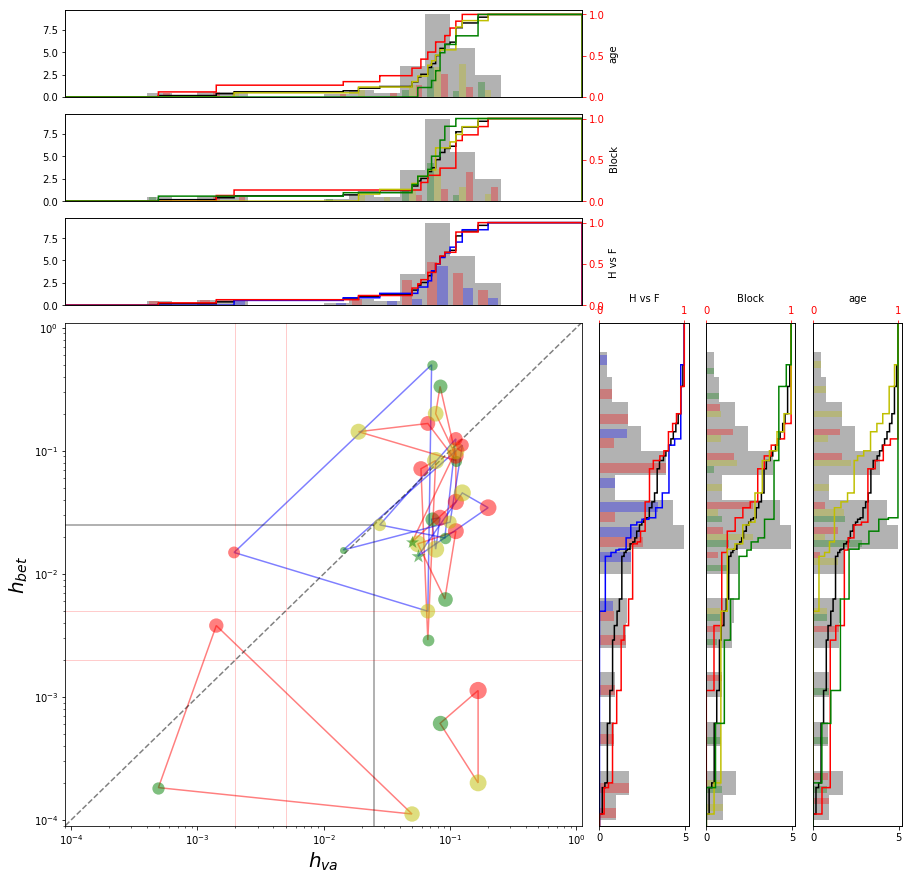



----------------------------------------------------------------------
h_va
----------------------------------------------------------------------

H vs F -> mannwhitneyu=0.4297  kruskal=0.8468  ks_2samp=0.9996
BLOCK 0 vs 1 -> mannwhitneyu=0.2912  kruskal=0.5628  ks_2samp=0.8690
BLOCK 0 vs 2 -> mannwhitneyu=0.0520  kruskal=0.0979  ks_2samp=0.0995
BLOCK 1 vs 2 -> mannwhitneyu=0.1764  kruskal=0.3379  ks_2samp=0.5361
AGE -26 vs 27-29 -> mannwhitneyu=0.1921  kruskal=0.3681  ks_2samp=0.6408
AGE -26 vs 30- -> mannwhitneyu=0.0438  kruskal=0.0812  ks_2samp=0.1590
AGE 27-29 vs 30- -> mannwhitneyu=0.1103  kruskal=0.2115  ks_2samp=0.7863


Coupe à h=0.002, tau=500.0
------------------------------

H vs F -> mannwhitneyu=0.5000  kruskal=0.9854  ks_2samp=0.9994
BLOCK 0 vs 1 -> mannwhitneyu=0.4145  kruskal=0.8050  ks_2samp=0.7771
BLOCK 0 vs 2 -> mannwhitneyu=0.0095  kruskal=0.0173  ks_2samp=0.0303
BLOCK 1 vs 2 -> mannwhitneyu=0.0314  kruskal=0.0583  ks_2samp=0.1342
AGE -26 vs 27-29 -> mannwhitneyu

In [18]:
fig = plot_fig(recording, max_tau=None, coupe=[1/500, 1/200])

---------------------------------

---------------------------------